# Enunciado

Tomar un ejemplo de los bots utilizados (uno de los dos) y construir el propio.
Sacar conclusiones de los resultados.
IMPORTANTE: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

# Instalación de dependencias

In [59]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

In [60]:
# Imports
import re
import unicodedata
import json
import string
import random
import numpy as np

import stanza
import spacy_stanza

import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Dropout

import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy

stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish)...
INFO:stanza:File exists: /root/stanza_resources/es/default.zip.
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


## Preprocesamiento

Eliminación de caracteres especiales, tildes y puntuaciones

In [62]:
# Abrimos el json de patrones de preguntas y respuestas
file_path = '/content/sample_data/intents.json'

with open(file_path) as intents_file:
    dataset = json.load(intents_file)

# Descomentar y comentar el codigo superior para ejecutar sobre el directorio
# with open('intents.json') as intents:
#     dataset = json.load(intents)

In [63]:
def preprocess_clean_text(text):
    # Sacamos las tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Quitamos los caracteres especiales
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    text = re.sub(pattern, '', text)
    # Quitamos los caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [64]:
# Definimos palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # Transformar la pregunta (input) en tokens y lematizar
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:
            words.append(token.lemma_)

        doc_X.append(pattern)
        doc_y.append(intent["tag"])

    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

<ipython-input-64-f728df1451d2>:15: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  tokens = nlp(preprocess_clean_text(pattern.lower()))
<ipython-input-64-f728df1451d2>:15: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['i', 'a', 'em', 'good']
Entities: []
  tokens = nlp(preprocess_clean_text(pattern.lower()))
<ipython-input-64-f728df1451d2>:15: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['i', 'a', 'em', 'fine']
Entities: []
  tokens = nlp(preprocess_clean_text(pattern.lower()))


In [65]:
# Clases y categorias que extraemos del dataset luego de las filtraciónes
print("Clases:\n", classes, '\n', '-'*100)
print("Categorias:\n", doc_y)

Clases:
 ['Identity', 'activity', 'age', 'appreciate', 'christian', 'contact', 'covid19', 'cricket', 'datetime', 'exclaim', 'goodbye', 'google', 'greeting', 'greetreply', 'haha', 'inspire', 'insult', 'jokes', 'news', 'nicetty', 'no', 'noanswer', 'options', 'programmer', 'riddle', 'song', 'suggest', 'thanks', 'timer', 'weather', 'whatsup'] 
 ----------------------------------------------------------------------------------------------------
Categorias:
 ['google', 'google', 'google', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'thanks', 'thanks', 'thanks', 'thanks', 'thanks', 'options', 'options', 'options', 'options', 'options', 'jokes', 'jokes', 'jokes', 'Identity', 'Identity', 'datetime', 'datetime', 'datetime', 'datetime', 'datetime', 'datetime', 'datetime', 'whatsup', 'whatsup', 'whatsup', 'whatsup', 'whatsup', 'haha', 'haha', 'haha', 'haha', 'haha', 'pr

In [66]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)

    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

<ipython-input-66-e332faa545aa>:10: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  tokens = nlp(preprocess_clean_text(doc.lower()))
<ipython-input-66-e332faa545aa>:10: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['i', 'a', 'em', 'good']
Entities: []
  tokens = nlp(preprocess_clean_text(doc.lower()))
<ipython-input-66-e332faa545aa>:10: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['i', 'a', 'em', 'fine']
Entities: []
  tokens = nlp(preprocess_clean_text(doc.lower()))


X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Entrenamiento

- Vemos las entradas y salidas.
- Definimos el modelo DNN para el entrenamiento.
- Le damos las entradas al modelo y entrenamos.

In [67]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (127,) output: 31


In [68]:
# Entrenamiento del modelo DNN, Modelo secuencial, regularizado usando softmax y adam como optimizador
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))
model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               16384     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 31)                2015      
                                                                 
Total params: 26,655
Trainable params: 26,655
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
# Print de epocas
hist = model.fit(x=train_X, y=train_y, epochs=300)

Epoch 1/300
4/4 [==============================] - 2s 5ms/step - loss: 3.4182 - accuracy: 0.0265
Epoch 2/300
4/4 [==============================] - 0s 5ms/step - loss: 3.4111 - accuracy: 0.0354
Epoch 3/300
4/4 [==============================] - 0s 5ms/step - loss: 3.3882 - accuracy: 0.0531
Epoch 4/300
4/4 [==============================] - 0s 7ms/step - loss: 3.3948 - accuracy: 0.0354
Epoch 5/300
4/4 [==============================] - 0s 5ms/step - loss: 3.3489 - accuracy: 0.0973
Epoch 6/300
4/4 [==============================] - 0s 4ms/step - loss: 3.3463 - accuracy: 0.0708
Epoch 7/300
4/4 [==============================] - 0s 4ms/step - loss: 3.3329 - accuracy: 0.0885
Epoch 8/300
4/4 [==============================] - 0s 4ms/step - loss: 3.3036 - accuracy: 0.1062
Epoch 9/300
4/4 [==============================] - 0s 5ms/step - loss: 3.3163 - accuracy: 0.1327
Epoch 10/300
4/4 [==============================] - 0s 5ms/step - loss: 3.3198 - accuracy: 0.1062
Epoch 11/300
4/4 [===========

Graficamos accuracy vs epocas para visualizar la performance del modelo

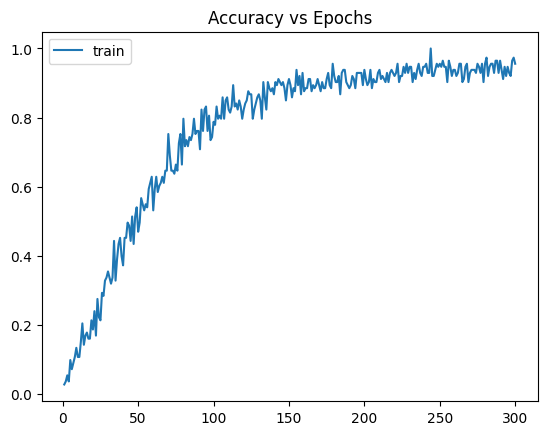

In [70]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.title('Accuracy vs Epochs')
plt.show()

In [71]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

## Testing y validación

In [72]:
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    return lemma_tokens

def bag_of_words(text, vocab):
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens:
        for idx, word in enumerate(vocab):
            if word == w:
                bow[idx] = 1
    return np.array(bow)

def pred_class(text, vocab, labels):
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # Si hubo reconocimiento
        # Array de softmax
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        # Filtra entradas menores a thresh
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # Ordenamiento de keys según el softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)

        for r in y_pred:
            return_list.append(labels[r[0]])

    return return_list

# Respuesta
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"]
    for i in list_of_intents:
        # Busca el tag en el intents y ofrece una respuesta de las definidas
        if i["tag"] == tag:
            result = random.choice(i["responses"])
            break
    return result

In [73]:
def start_chat():
    print("Bienvenido!, ingrese una consulta.\n (O ingrese 'salir' para finalizar)")
    while True:
        message = input("")
        print("Q:", message)
        if message.lower() == 'salir':
            break

        intents = pred_class(message, words, classes)
        if len(intents) > 0:
            result = get_response(intents, dataset)
            print("BOT:", result)
        else:
            print("BOT: No entiendo la pregunta!")

In [74]:
start_chat()

Bienvenido!, ingrese una consulta.
 (O ingrese 'salir' para finalizar)
Hi!
Q: Hi!
1/1 [==============================] - 0s 53ms/step
BOT: Hello
How are you
Q: How are you
1/1 [==============================] - 0s 21ms/step
BOT: Good to see you again
What you can do?
Q: What you can do?
1/1 [==============================] - 0s 19ms/step
BOT: I am a general purpose chatbot. My capabilities are : 
 1. I can chat with you. Try asking me for jokes or riddles! 
 2. Ask me the date and time 
 3. I can google search for you. Use format google: your query 
 4. I can get the present weather for any city. Use format weather: city name 
 5. I can get you the top 10 trending news in India. Use keywords 'Latest News' 
 6. I can get you the top 10 trending songs globally. Type 'songs' 
 7. I can set a timer for you. Enter 'set a timer: minutes to timer' 
 8. I can get the present Covid stats for any country. Use 'covid 19: world' or 'covid 19: country name' 
 For suggestions to help me improve, sen